# Importing necessary libraries and data

In [116]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
# To tune a model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import lightgbm as lgb


from utils import (
    col_out,
    model_summary,
    adj_r2_score,
    model_performance_regression,
    confusion_matrix_helper,
    model_performance_classification_sklearn,
)

import sklearn.metrics as metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config

set_config(display='diagram')
from sklearn.preprocessing import FunctionTransformer


from numpy import loadtxt
from xgboost import XGBClassifier

# Loading and Reading data

In [117]:
#Load data
data = pd.read_csv("M1_final.csv")

In [118]:
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,...,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,...,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,...,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,...,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,...,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,...,32,58,W,24,35,29.91,Fair / Windy,9,17,13


In [119]:
data.shape

(28820, 23)

In [120]:
data.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM',
       'DEST', 'DEP_DELAY', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_M',
       'DEP_TIME_M', 'CRS_ARR_M', 'Temperature', 'Dew Point', 'Humidity',
       'Wind', 'Wind Speed', 'Wind Gust', 'Pressure', 'Condition', 'sch_dep',
       'sch_arr', 'TAXI_OUT'],
      dtype='object')

# Renaming columns to make it consistent

In [121]:
df_column_dict = {column: column.replace(' ', '_') for column in data.columns}
data = data.rename(columns=df_column_dict)
data.columns = data.columns.str.upper()
data.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM',
       'DEST', 'DEP_DELAY', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_M',
       'DEP_TIME_M', 'CRS_ARR_M', 'TEMPERATURE', 'DEW_POINT', 'HUMIDITY',
       'WIND', 'WIND_SPEED', 'WIND_GUST', 'PRESSURE', 'CONDITION', 'SCH_DEP',
       'SCH_ARR', 'TAXI_OUT'],
      dtype='object')

# Dropping dulpicate rows

In [122]:
#dropping duplicates if any
data.drop_duplicates(inplace=True)
data.shape

(28820, 23)

# Dropping unnecessary columns from dataset

In [123]:
#dropping unnecessary columns
#1.day of month is not needed because we have day_of_week in the dataset.
#2. tail num is unique to row and will not help in modelling.


# Drop unwanted columns
columns_to_drop = ['DAY_OF_MONTH', 'TAIL_NUM']
data = data.drop(columns = columns_to_drop, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28820 entries, 0 to 28819
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_WEEK        28820 non-null  int64  
 2   OP_UNIQUE_CARRIER  28820 non-null  object 
 3   DEST               28820 non-null  object 
 4   DEP_DELAY          28820 non-null  int64  
 5   CRS_ELAPSED_TIME   28820 non-null  int64  
 6   DISTANCE           28820 non-null  int64  
 7   CRS_DEP_M          28820 non-null  int64  
 8   DEP_TIME_M         28820 non-null  int64  
 9   CRS_ARR_M          28820 non-null  int64  
 10  TEMPERATURE        28820 non-null  int64  
 11  DEW_POINT          28820 non-null  object 
 12  HUMIDITY           28820 non-null  int64  
 13  WIND               28818 non-null  object 
 14  WIND_SPEED         28820 non-null  int64  
 15  WIND_GUST          28820 non-null  int64  
 16  PRESSURE           288

In [124]:
data['DEW_POINT'] = data['DEW_POINT'].astype('int64') # convert dew_point type object to integer

In [125]:
data['DEW_POINT'].value_counts()

 33    1349
 34    1156
 30    1132
 35    1124
 32    1116
 31    1070
 24     931
 27     862
 25     847
 39     843
 28     816
 29     759
 23     751
 45     697
 26     686
 37     678
 42     671
 46     651
 18     600
 38     600
 20     544
 41     534
 22     525
 21     520
 43     511
 36     507
 40     499
 44     469
 16     447
 51     442
 15     429
 48     420
 8      371
 47     361
 52     318
 13     314
 9      305
 19     303
 17     296
 14     289
 50     274
 5      249
 49     247
 12     242
 7      235
 54     226
 53     212
 11     180
 10     147
 3      138
 4      133
 6      130
-3      128
 55     128
-2       81
 0       75
-1       65
 1       61
 58      31
 56      29
 2       28
 59      22
 57      13
 67       3
Name: DEW_POINT, dtype: int64

In [126]:
# There are only 2 NAs in wind. Dropping these rows will not impact dataset much, hence dropping 2 rows.
data = data.dropna(subset=['WIND'])

In [127]:
#convert cardinal directions (N,S,E,W) into degrees in the colmn "wind_dict"
wind_dict = {'NNW': 340, 'CALM': 0, 'NNE':20, 'NE':45, 'VAR':0, 'WSW':230, 'S':180, 'SSW':200, 'WNW':290, 'ESE':115, 'N': 360, 'SW':225, 'E':90, 'W':270, 'SSE':155, 'ENE':70, 'NW':315, 'SE':135}

for item in wind_dict:
    data.loc[data['WIND'] == item, "WIND"] = wind_dict[item] 
    
data['WIND'] = data['WIND'].astype('int64')

data.head(10)

,MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,DEP_TIME_M,CRS_ARR_M,...,DEW_POINT,HUMIDITY,WIND,WIND_SPEED,WIND_GUST,PRESSURE,CONDITION,SCH_DEP,SCH_ARR,TAXI_OUT
0,11,5,B6,CHS,-1,124,636,324,323,448,...,34,58,270,25,38,29.86,Fair / Windy,9,17,14
1,11,5,B6,LAX,-7,371,2475,340,333,531,...,34,58,270,25,38,29.86,Fair / Windy,9,17,15
2,11,5,B6,FLL,40,181,1069,301,341,482,...,34,58,270,25,38,29.86,Fair / Windy,9,17,22
3,11,5,B6,MCO,-2,168,944,345,343,513,...,34,58,270,25,38,29.86,Fair / Windy,9,17,12
4,11,5,DL,ATL,-4,139,760,360,356,499,...,32,58,270,24,35,29.91,Fair / Windy,9,17,13
5,11,5,AA,ORD,-1,161,740,359,358,460,...,32,58,270,24,35,29.91,Fair / Windy,9,17,21
6,11,5,AA,LAX,-1,373,2475,360,359,553,...,32,58,270,24,35,29.91,Fair / Windy,9,17,26
7,11,5,B6,BUF,-5,80,301,365,360,445,...,32,58,270,24,35,29.91,Fair / Windy,17,21,11
8,11,5,B6,LGB,0,368,2465,365,365,553,...,32,58,270,24,35,29.91,Fair / Windy,17,21,25
9,11,5,B6,FLL,3,184,1069,370,373,554,...,32,58,270,24,35,29.91,Fair / Windy,17,21,29


In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28818 entries, 0 to 28819
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28818 non-null  int64  
 1   DAY_OF_WEEK        28818 non-null  int64  
 2   OP_UNIQUE_CARRIER  28818 non-null  object 
 3   DEST               28818 non-null  object 
 4   DEP_DELAY          28818 non-null  int64  
 5   CRS_ELAPSED_TIME   28818 non-null  int64  
 6   DISTANCE           28818 non-null  int64  
 7   CRS_DEP_M          28818 non-null  int64  
 8   DEP_TIME_M         28818 non-null  int64  
 9   CRS_ARR_M          28818 non-null  int64  
 10  TEMPERATURE        28818 non-null  int64  
 11  DEW_POINT          28818 non-null  int64  
 12  HUMIDITY           28818 non-null  int64  
 13  WIND               28818 non-null  int64  
 14  WIND_SPEED         28818 non-null  int64  
 15  WIND_GUST          28818 non-null  int64  
 16  PRESSURE           288

In [129]:
#Month is currently of type int, changing it to object by giving it month names.
month_mapping = {1: 'JAN', 11: 'NOV', 12: 'DEC'}

# Use the map function to convert the 'MONTH' column
data['MONTH'] = data['MONTH'].map(month_mapping)
data['MONTH'] = data['MONTH'].astype(str)

In [130]:
#pulling weekend and week day information from the column names day_of_week
# Create a mapping dictionary
day_mapping = {1: 'weekday', 2: 'weekday', 3: 'weekday', 4: 'weekday', 5: 'weekday', 6: 'weekend', 7: 'weekend'}


# Use the map function to convert the 'DAY_OF_WEEK' column
data['DAY_OF_WEEK'] = data['DAY_OF_WEEK'].map(day_mapping)
data['DAY_OF_WEEK'] = data['DAY_OF_WEEK'].astype(str)

In [131]:
data.MONTH.value_counts()


JAN    9869
NOV    9769
DEC    9180
Name: MONTH, dtype: int64

In [132]:
data['DAY_OF_WEEK'].value_counts()

weekday    20970
weekend     7848
Name: DAY_OF_WEEK, dtype: int64

# EDA and Data Preprocessing

([<matplotlib.axis.XTick at 0x2954906ab80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

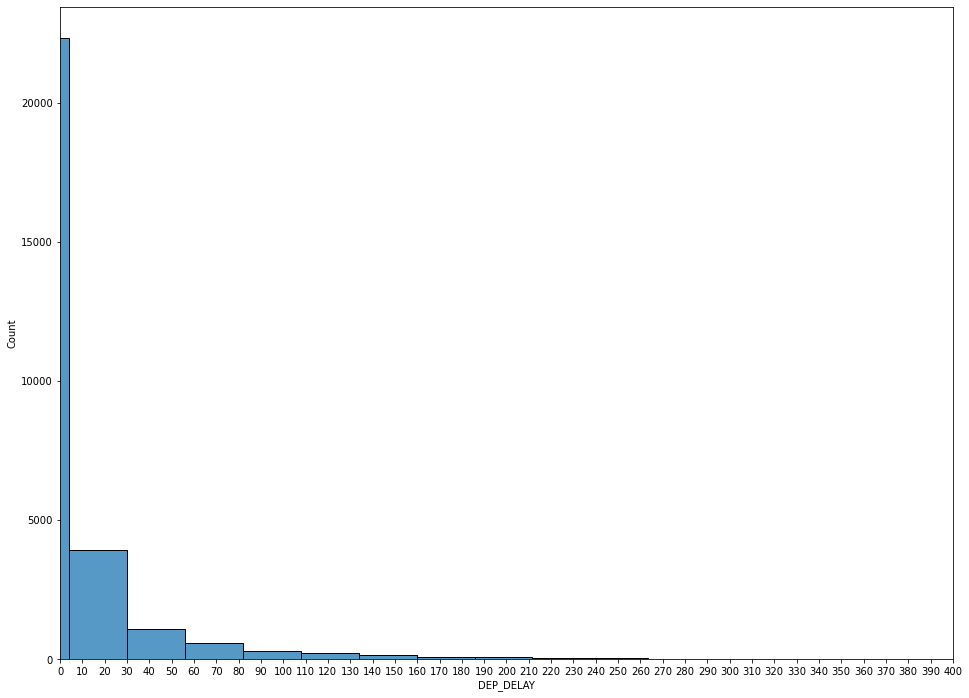

In [133]:
# Checking distribution of target column
plt.figure(figsize=(16, 12))
sns.histplot(data=data, x='DEP_DELAY', bins=50)
plt.xlim(0, 400)
plt.xticks(np.arange(0, 401, 10))

In [134]:
data['DEP_DELAY'].value_counts()

-5       2899
-4       2476
-3       2300
-6       2169
-2       2018
-7       1977
-1       1819
 0       1466
-8       1412
-9        964
-10       729
 1        555
 2        434
-11       345
 4        339
 3        333
 5        267
 6        265
 7        243
 8        241
 10       234
 9        230
-12       192
 12       174
 11       159
 13       156
 14       153
 15       147
 17       130
 18       129
 16       126
-13       122
 22       120
 21       118
 19       106
 20        96
 25        84
 24        79
 30        71
 27        71
 32        69
 26        69
 23        68
 29        68
 33        66
 37        64
 31        63
 28        60
 43        55
-14        55
 34        46
 39        45
 41        43
 38        43
 36        42
 42        41
 35        41
 40        40
 44        39
-15        37
 56        35
 52        34
 54        34
 48        32
 50        31
 71        31
 47        30
 46        30
 53        29
 49        29
 60        28
 66   

In [135]:
data.shape

(28818, 21)

# Categorical columns- Bivariate Analysis

<AxesSubplot:xlabel='OP_UNIQUE_CARRIER', ylabel='count'>

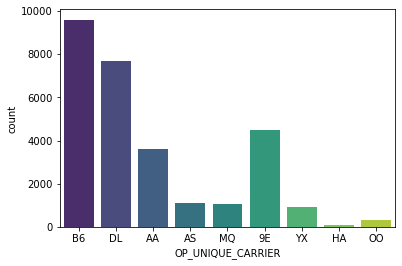

In [136]:
# count of op_unique_carrier
sns.countplot(x='OP_UNIQUE_CARRIER', data=data, palette='viridis')

We see that the carrier B6 has the most # of flights.

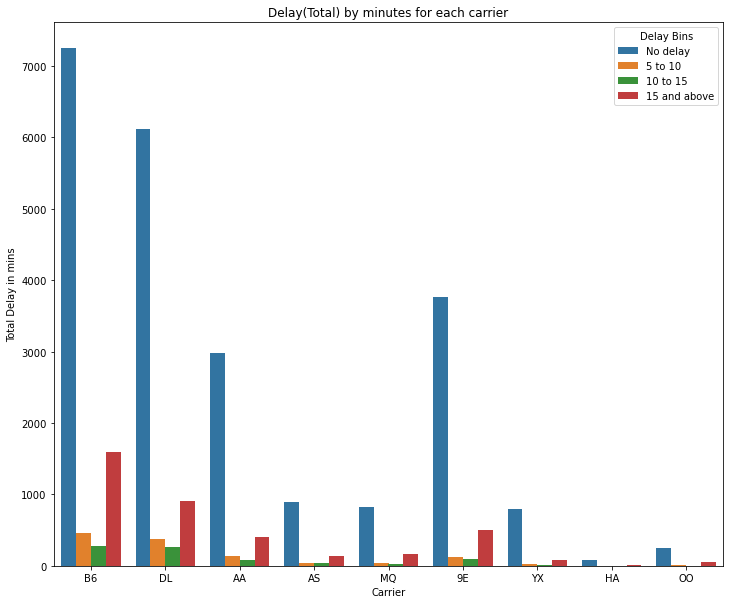

In [137]:
#checking delay(Total) by minutes for each carrier
data['DelayCategory'] = pd.cut(data['DEP_DELAY'], bins=[-float('inf'), 5, 10, 15, float('inf')],
                               labels=['No delay', '5 to 10', '10 to 15', '15 and above'])
plt.figure(figsize=(12, 10))
sns.countplot(data=data, x='OP_UNIQUE_CARRIER', hue='DelayCategory')
plt.title('Delay(Total) by minutes for each carrier')
plt.xlabel('Carrier')
plt.ylabel('Total Delay in mins')
plt.legend(title='Delay Bins')
plt.show()

In [138]:
# Drop the column added above
columns_to_drop = ['DelayCategory']
data = data.drop(columns = columns_to_drop, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28818 entries, 0 to 28819
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28818 non-null  object 
 1   DAY_OF_WEEK        28818 non-null  object 
 2   OP_UNIQUE_CARRIER  28818 non-null  object 
 3   DEST               28818 non-null  object 
 4   DEP_DELAY          28818 non-null  int64  
 5   CRS_ELAPSED_TIME   28818 non-null  int64  
 6   DISTANCE           28818 non-null  int64  
 7   CRS_DEP_M          28818 non-null  int64  
 8   DEP_TIME_M         28818 non-null  int64  
 9   CRS_ARR_M          28818 non-null  int64  
 10  TEMPERATURE        28818 non-null  int64  
 11  DEW_POINT          28818 non-null  int64  
 12  HUMIDITY           28818 non-null  int64  
 13  WIND               28818 non-null  int64  
 14  WIND_SPEED         28818 non-null  int64  
 15  WIND_GUST          28818 non-null  int64  
 16  PRESSURE           288

B6 has the most # of delays(but this also has the most number of flights) followed by the carrier DL.

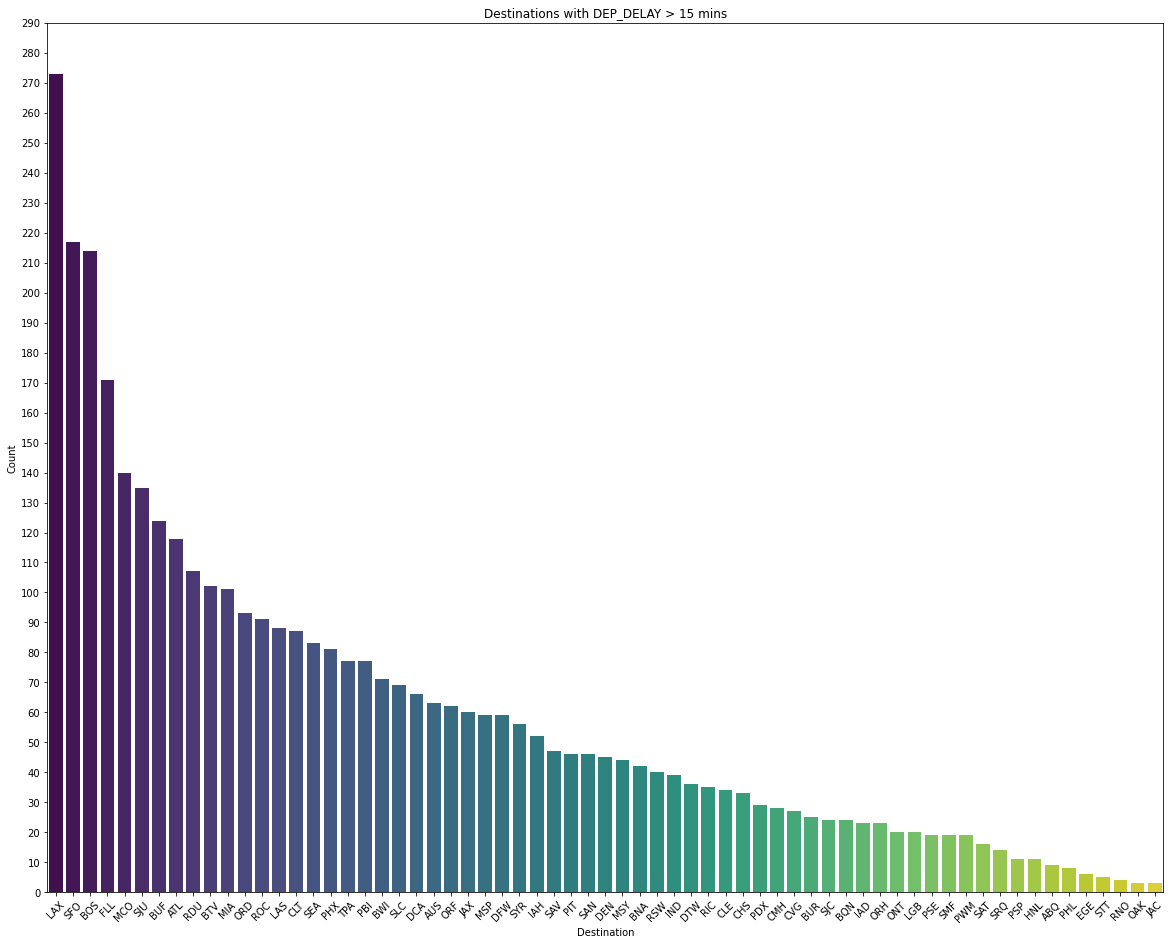

In [139]:
#Checking destinations with DEP_DELAY > 15 mins
plt.figure(figsize=(20, 16))

# Filter data for flights with DEP_DELAY > 20 mins
filtered_data = data[data['DEP_DELAY'] > 15]
ordered_destinations = filtered_data['DEST'].value_counts().index

# Create a barplot
sns.countplot(x='DEST', data=filtered_data, order=ordered_destinations, palette='viridis')

# Customize the plot
plt.title('Destinations with DEP_DELAY > 15 mins')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.yticks(np.arange(0, 300, 10))

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

Flights running to LAX, SFO and BOS have the most number of departure delays

In [140]:

data["CONDITION"].value_counts()

Mostly Cloudy            9122
Fair                     5038
Cloudy                   4992
Partly Cloudy            3209
Light Rain               1865
Mostly Cloudy / Windy    1442
Fair / Windy              918
Partly Cloudy / Windy     582
Rain                      351
Cloudy / Windy            341
Light Rain / Windy        288
Light Drizzle             194
Fog                       147
Wintry Mix                 83
Light Snow                 76
Heavy Rain                 54
Fog / Windy                28
Rain / Windy               25
Light Snow / Windy         24
Light Drizzle / Windy      18
Heavy Rain / Windy          6
Drizzle and Fog             5
Light Freezing Rain         4
Wintry Mix / Windy          4
Snow                        2
Name: CONDITION, dtype: int64

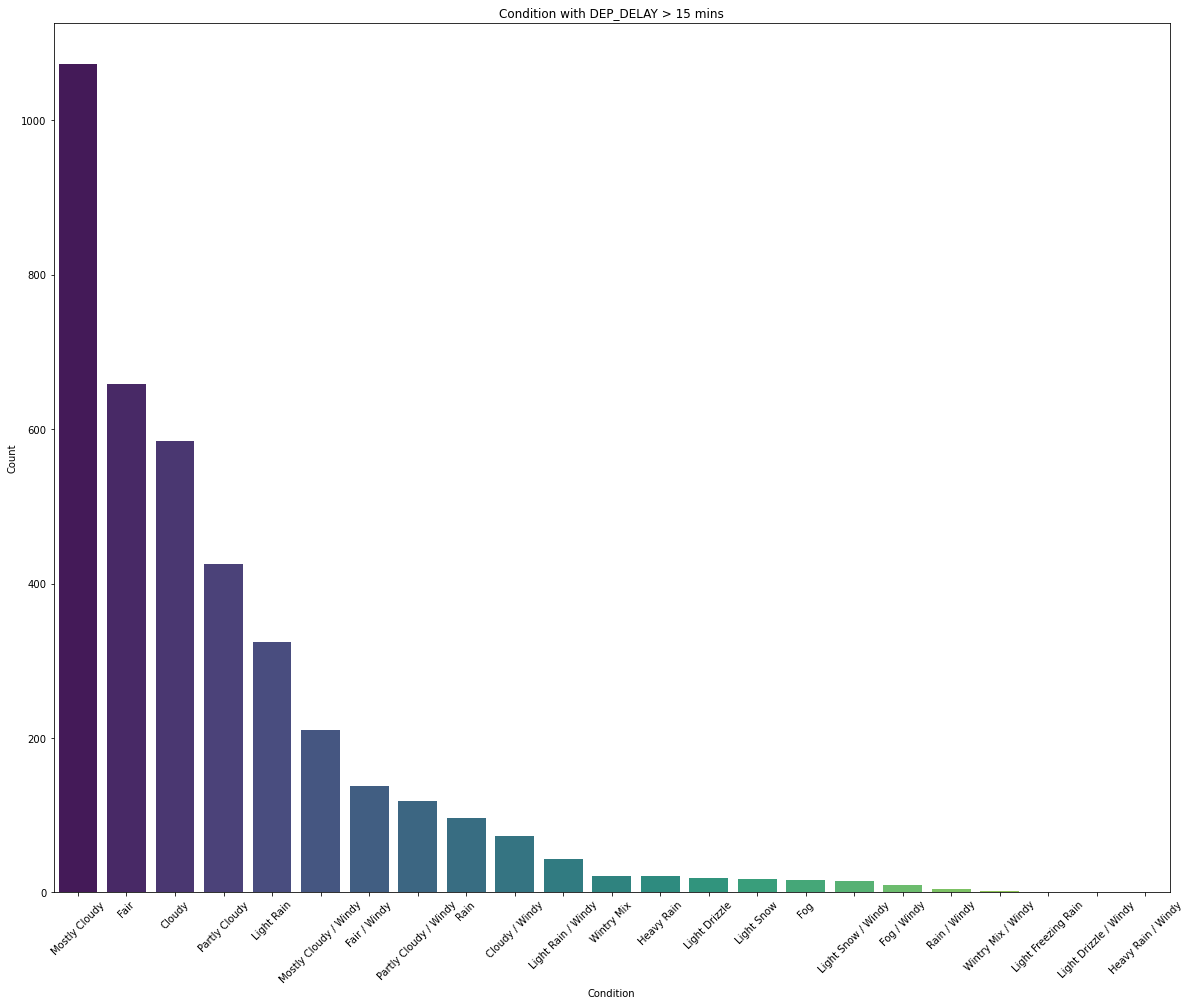

In [141]:
# Filter data for flights with DEP_DELAY > 15 mins
plt.figure(figsize=(20, 16))

filtered_data = data[data['DEP_DELAY'] > 15]
ordered_destinations = filtered_data['CONDITION'].value_counts().index

# Create a barplot
sns.countplot(x='CONDITION', data=filtered_data, order=ordered_destinations, palette='viridis')

# Customize the plot
plt.title('Condition with DEP_DELAY > 15 mins')
plt.xlabel('Condition')
plt.ylabel('Count')

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

When the condition is Mostly Cloudy, there are more number of flight departure delays. Interestingly, even though the condition is Fair, there are many departure delays.

In [142]:
data.isnull().sum()

MONTH                0
DAY_OF_WEEK          0
OP_UNIQUE_CARRIER    0
DEST                 0
DEP_DELAY            0
CRS_ELAPSED_TIME     0
DISTANCE             0
CRS_DEP_M            0
DEP_TIME_M           0
CRS_ARR_M            0
TEMPERATURE          0
DEW_POINT            0
HUMIDITY             0
WIND                 0
WIND_SPEED           0
WIND_GUST            0
PRESSURE             0
CONDITION            0
SCH_DEP              0
SCH_ARR              0
TAXI_OUT             0
dtype: int64

In [143]:
#numerical columns
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()
numeric_columns

['DEP_DELAY',
 'CRS_ELAPSED_TIME',
 'DISTANCE',
 'CRS_DEP_M',
 'DEP_TIME_M',
 'CRS_ARR_M',
 'TEMPERATURE',
 'DEW_POINT',
 'HUMIDITY',
 'WIND',
 'WIND_SPEED',
 'WIND_GUST',
 'PRESSURE',
 'SCH_DEP',
 'SCH_ARR',
 'TAXI_OUT']

In [144]:
#categorical columns
categorical_columns = data.select_dtypes(include=np.object_).columns.tolist()
categorical_columns

['MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'DEST', 'CONDITION']

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28818 entries, 0 to 28819
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28818 non-null  object 
 1   DAY_OF_WEEK        28818 non-null  object 
 2   OP_UNIQUE_CARRIER  28818 non-null  object 
 3   DEST               28818 non-null  object 
 4   DEP_DELAY          28818 non-null  int64  
 5   CRS_ELAPSED_TIME   28818 non-null  int64  
 6   DISTANCE           28818 non-null  int64  
 7   CRS_DEP_M          28818 non-null  int64  
 8   DEP_TIME_M         28818 non-null  int64  
 9   CRS_ARR_M          28818 non-null  int64  
 10  TEMPERATURE        28818 non-null  int64  
 11  DEW_POINT          28818 non-null  int64  
 12  HUMIDITY           28818 non-null  int64  
 13  WIND               28818 non-null  int64  
 14  WIND_SPEED         28818 non-null  int64  
 15  WIND_GUST          28818 non-null  int64  
 16  PRESSURE           288

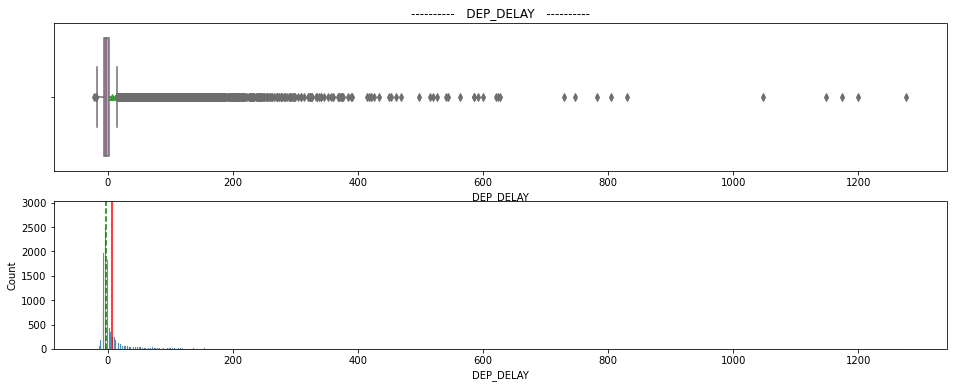

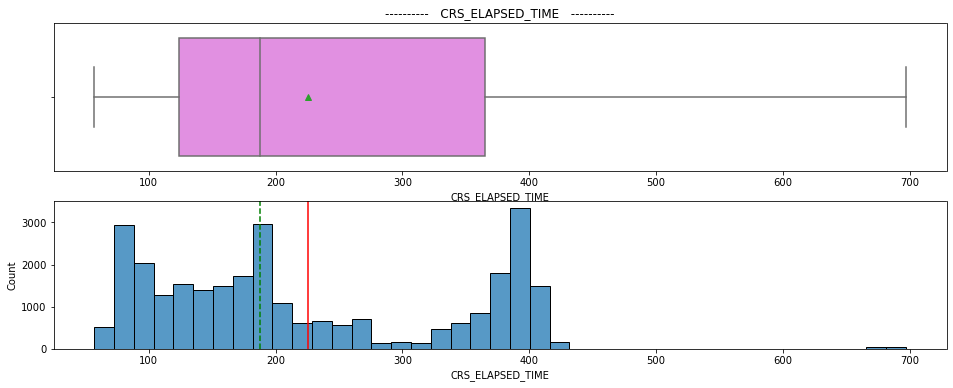

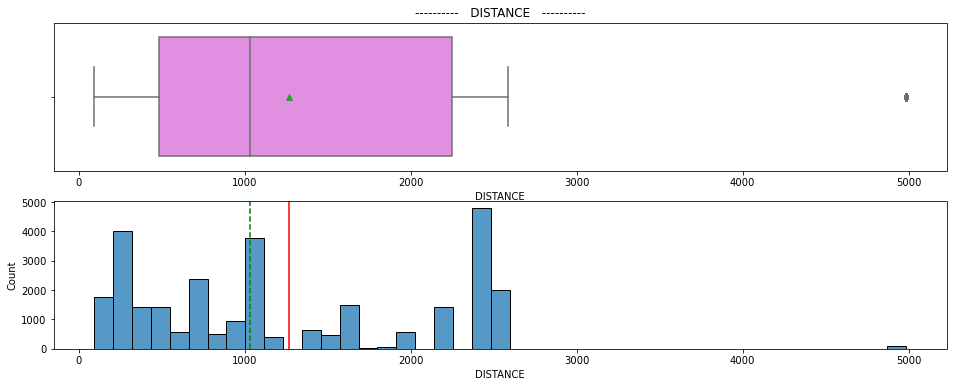

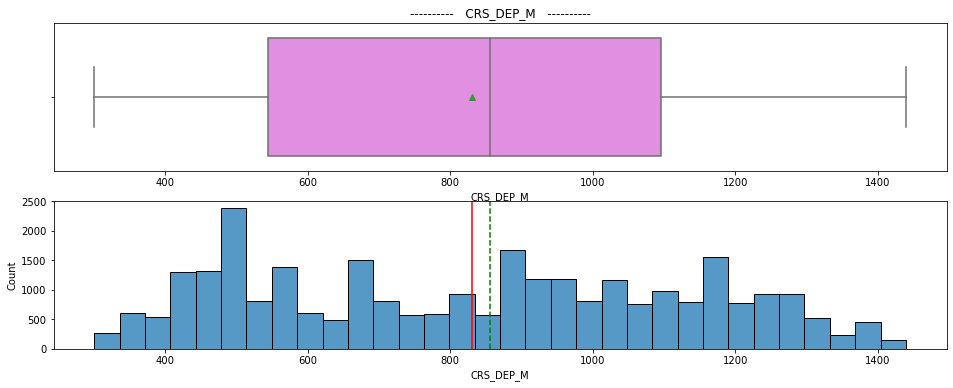

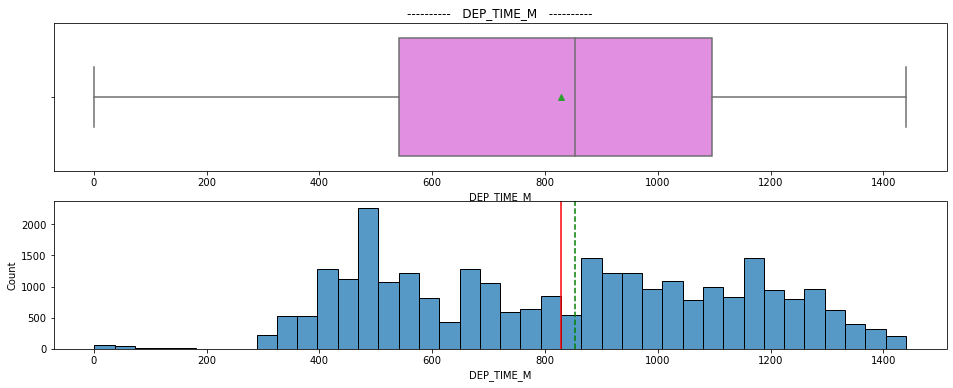

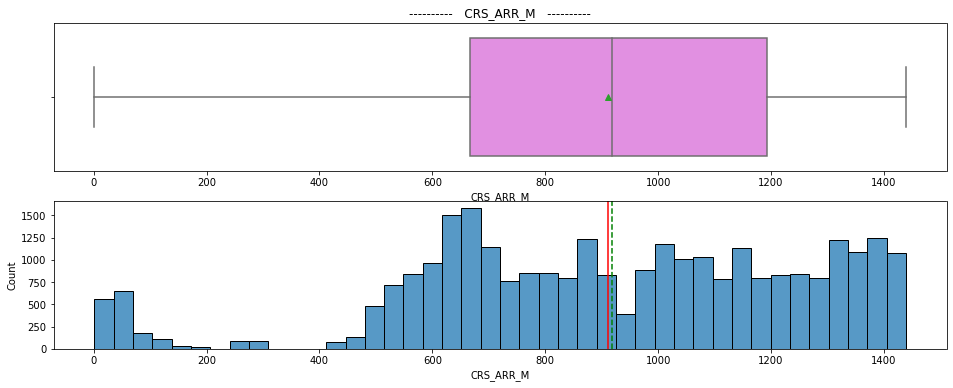

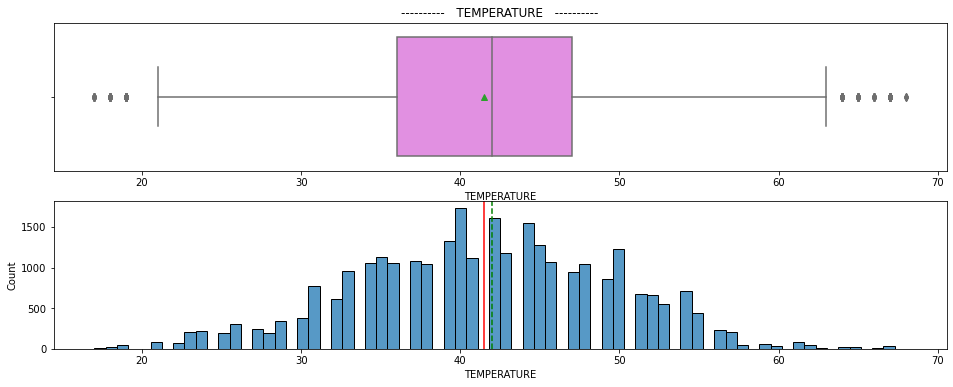

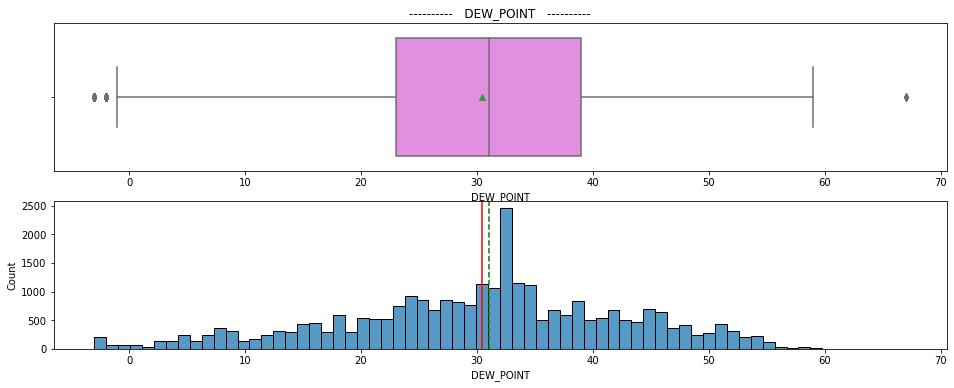

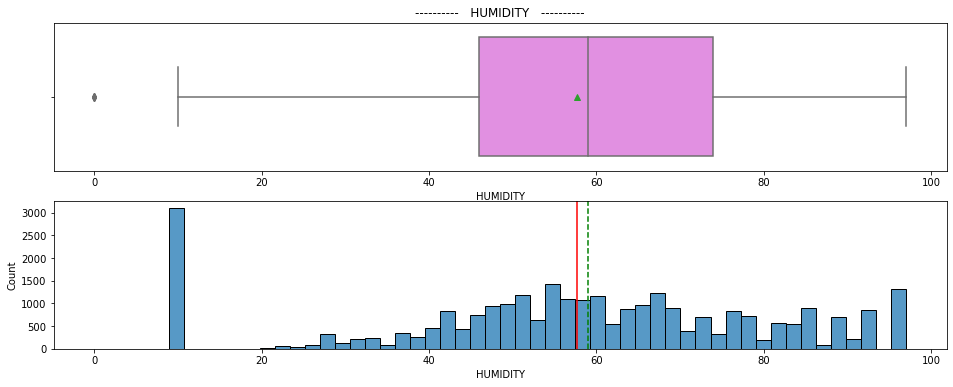

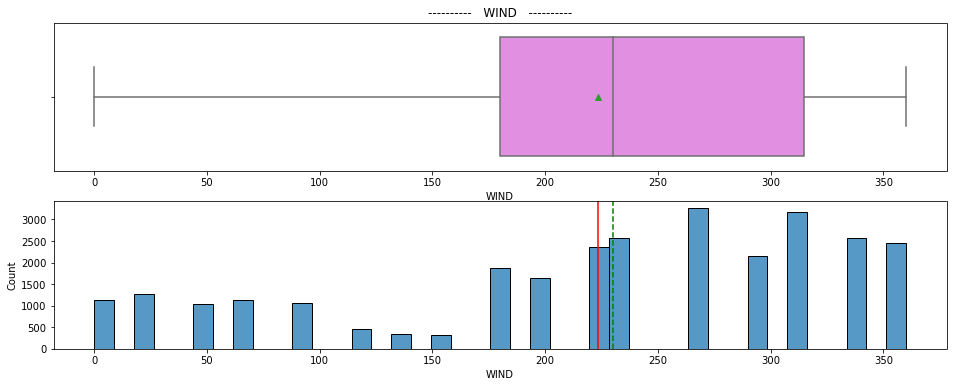

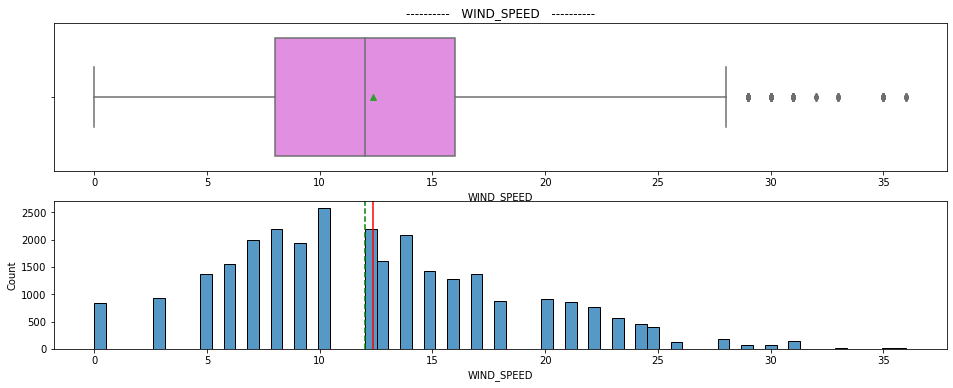

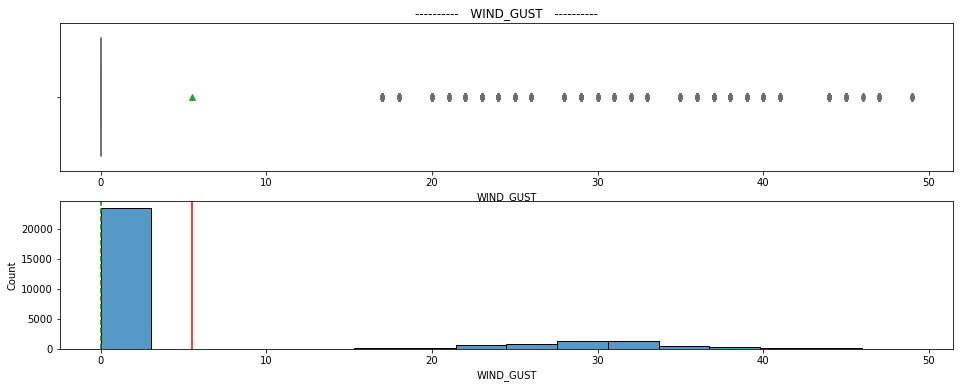

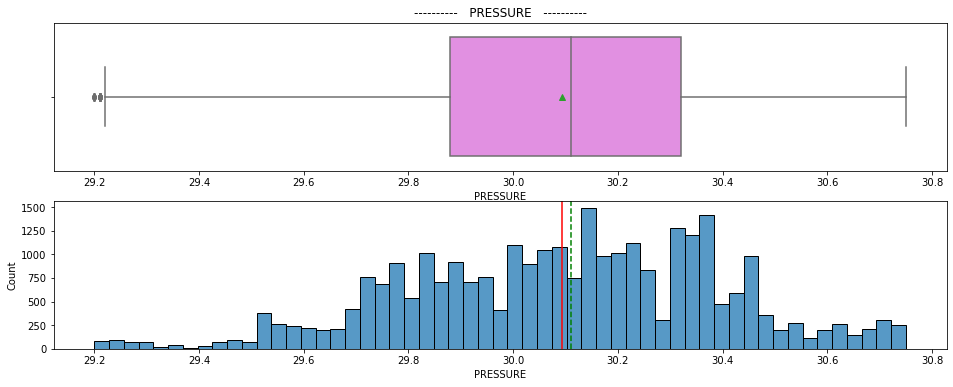

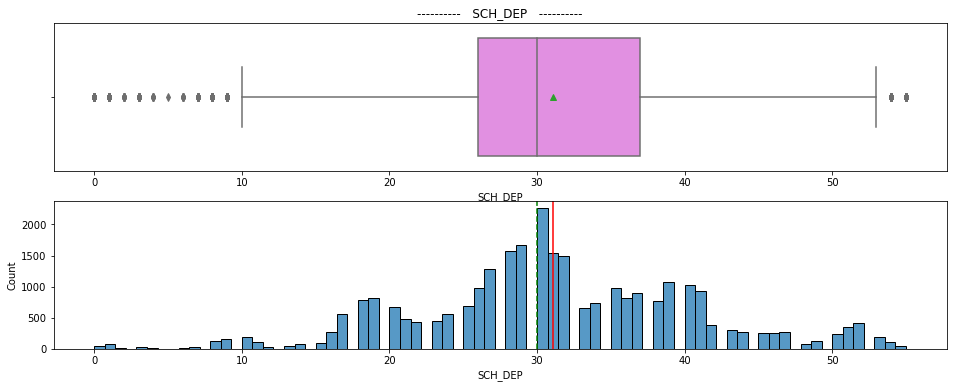

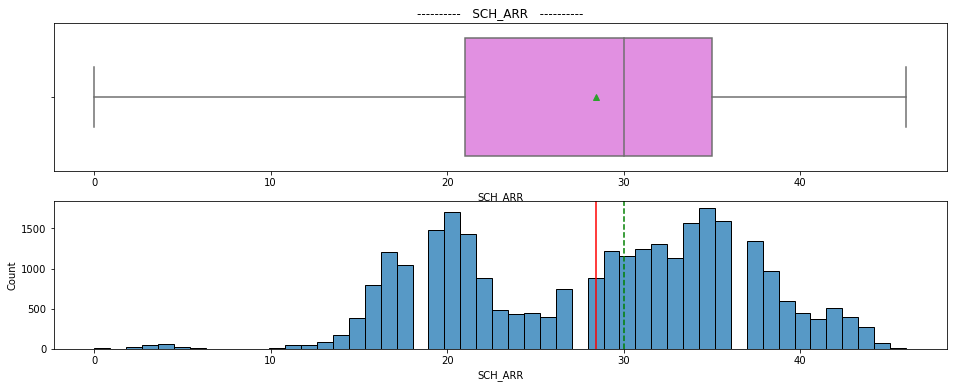

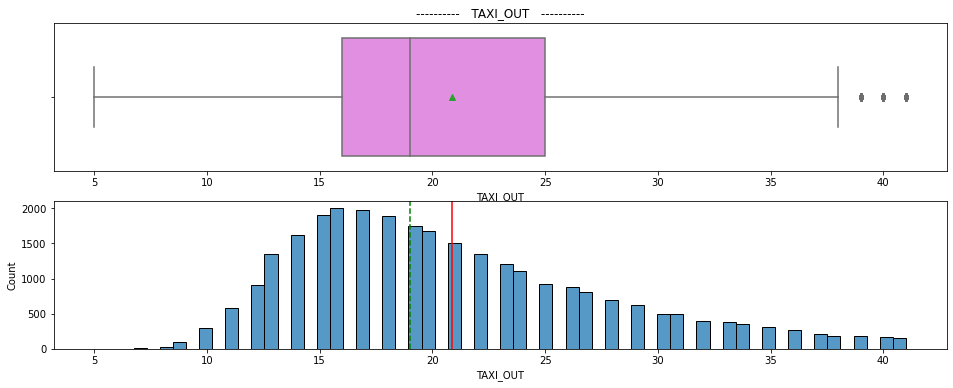

In [146]:
#Univariate and bivariate analysis
#exploring numerical columnss
for col in numeric_columns:
    plt.figure(figsize=(16, 6))
    plt.subplot(2, 1, 1)
    plt.title("----------   " + col + "   ----------")
    sns.boxplot(data=data, x=col, showmeans=True, color="violet")
    plt.subplot(2, 1, 2)
    sns.histplot(data=data, x=col)
    plt.axvline(data[col].mean(), color="red", linestyle="-")
    plt.axvline(data[col].median(), color="green", linestyle="--")
    plt.show()

The columns 'CRS_ELAPSED_TIME', 'WIND_GUST' are right skewed and need transformations

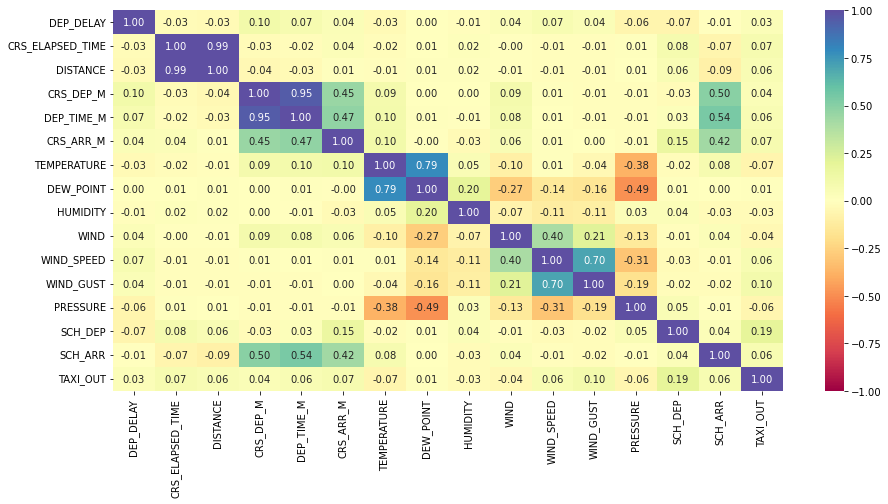

In [147]:
# correlation heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

From the above heatmap, we can see that DEP_TIME_M and CRS_DEP_M are highly correlated, hence drop DEP_TIME_M. DISTANCE and CRS_ELAPSED_TIME are also highly correlated, hence drop Distance.

# Dropping highly correlated columns

In [148]:
# Drop one of highly correlated columns DEP_TIME_M and CRS_DEP_M. 
# Also dropping TAXI_OUT and CRS_ARR_M as these features introduce Feature leakage (will not be availble during testing).
columns_to_drop = ['DISTANCE', 'CRS_ARR_M', 'DEP_TIME_M', 'TAXI_OUT']
data = data.drop(columns = columns_to_drop, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28818 entries, 0 to 28819
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28818 non-null  object 
 1   DAY_OF_WEEK        28818 non-null  object 
 2   OP_UNIQUE_CARRIER  28818 non-null  object 
 3   DEST               28818 non-null  object 
 4   DEP_DELAY          28818 non-null  int64  
 5   CRS_ELAPSED_TIME   28818 non-null  int64  
 6   CRS_DEP_M          28818 non-null  int64  
 7   TEMPERATURE        28818 non-null  int64  
 8   DEW_POINT          28818 non-null  int64  
 9   HUMIDITY           28818 non-null  int64  
 10  WIND               28818 non-null  int64  
 11  WIND_SPEED         28818 non-null  int64  
 12  WIND_GUST          28818 non-null  int64  
 13  PRESSURE           28818 non-null  float64
 14  CONDITION          28818 non-null  object 
 15  SCH_DEP            28818 non-null  int64  
 16  SCH_ARR            288

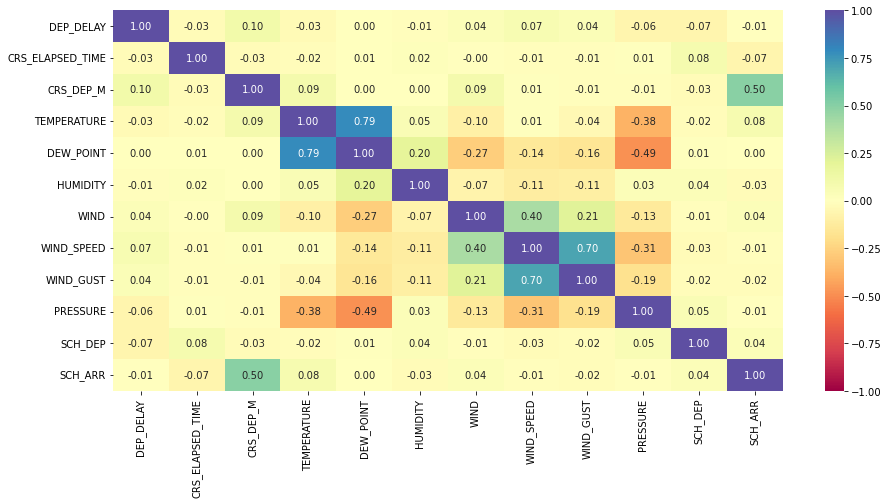

In [149]:
# checking correlation heatmap again
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

In [150]:
#These columns do not need any transformation
num_cols_scale_no_transform = ['CRS_DEP_M', 'TEMPERATURE', 'HUMIDITY',
       'WIND_SPEED', 'PRESSURE', 'SCH_DEP',
       'SCH_ARR']

In [151]:
# Randomly select 10 rows from the dataset to consider this data as useen data.
np.random.seed(42)
random_rows = np.random.choice(data.index, size=10, replace=False)
test_rows = data.loc[random_rows]

# The rest of the rows for the other dataframe
data = data.drop(random_rows)

# Creating pipeline

In [152]:
# creating pipeline (steps for data transformations - log, missing value imputation- KNN, scaling - MinMax, and encoding- Onehot)
col_transformer = make_pipeline(
    ColumnTransformer(
        transformers= [
            ('imputeScale',
                Pipeline([
                    ('KNNImpute', KNNImputer(n_neighbors=3)),
                    ('logTransform', FunctionTransformer(np.log1p, feature_names_out=col_out, validate=True)),
                    ('scaler', MinMaxScaler()),
                ]),['CRS_ELAPSED_TIME' , 'WIND_GUST']),
            ('scale',
                Pipeline([
                    ('KNNImpute', KNNImputer(n_neighbors=3)),
                    ('scaler', MinMaxScaler()),
                ]),num_cols_scale_no_transform),    
            ('imputeOneHot',
                Pipeline([
                    ('SimpleImpute', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
                    ('oneHotEncode', OneHotEncoder()),
                ]), categorical_columns),
        ],
        verbose_feature_names_out=False,
        remainder='passthrough'
    )
)

### Assuming departures with more than 15 mins delay as actual departure delays

In [153]:
data['DEP_DELAY'] = data['DEP_DELAY'].apply(lambda x: 0 if x <= 15 else 1)
data.shape

(28808, 17)

In [154]:
data['DEP_DELAY'].value_counts()

0    24936
1     3872
Name: DEP_DELAY, dtype: int64

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28808 entries, 0 to 28819
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28808 non-null  object 
 1   DAY_OF_WEEK        28808 non-null  object 
 2   OP_UNIQUE_CARRIER  28808 non-null  object 
 3   DEST               28808 non-null  object 
 4   DEP_DELAY          28808 non-null  int64  
 5   CRS_ELAPSED_TIME   28808 non-null  int64  
 6   CRS_DEP_M          28808 non-null  int64  
 7   TEMPERATURE        28808 non-null  int64  
 8   DEW_POINT          28808 non-null  int64  
 9   HUMIDITY           28808 non-null  int64  
 10  WIND               28808 non-null  int64  
 11  WIND_SPEED         28808 non-null  int64  
 12  WIND_GUST          28808 non-null  int64  
 13  PRESSURE           28808 non-null  float64
 14  CONDITION          28808 non-null  object 
 15  SCH_DEP            28808 non-null  int64  
 16  SCH_ARR            288

In [156]:
# split the data into training and test sets before running them through the preprocessing pipeline
X = data.drop("DEP_DELAY", axis=1)
y = data["DEP_DELAY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [157]:
X_train.shape

(20165, 16)

# Oversampling to overcome class imbalance in Target column

In [158]:
# # Assign y_train as a new column to X_train DataFrame
# X_train['TargetColumn'] = y_train.values

In [159]:
# X_train[X_train['TargetColumn'] == 1].count() # 0 = 17454, 1 = 2711

In [160]:
# sample = X_train[X_train['TargetColumn'] == 1].sample(14743, replace=True)
# sample.head()

In [161]:
# # Oversample the minority class by duplicating samples
# oversampled = pd.concat([X_train, sample], axis=0, ignore_index=True)
# oversampled.shape

In [162]:
# # Shuffle the DataFrame using sample() method
# shuffled_df = oversampled.sample(frac=1, random_state=42) 
# # Reset the index if needed
# shuffled_df.reset_index(drop=True, inplace=True)

In [163]:
# X_train = shuffled_df.drop('TargetColumn', axis = 1)
# y_train = shuffled_df['TargetColumn'].values

In [164]:
# X_train.shape

In [165]:
# y_train.shape

# Pycaret

In [166]:
from pycaret.classification import *

# Assuming your DataFrame is named 'data'
clf_setup = setup(data, target='DEP_DELAY', session_id=123)

# Compare classification models
clf_compare = compare_models()

# Choose the best model
best_model = create_model(clf_compare)

# Evaluate the best model
evaluate_model(best_model)

# Pipeline for Logistic Regression

In [167]:
# pipeline for Logistic Regression

# using column transformer and pipeline help in avoiding data leakage.
lasso_logreg_pipeline = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('lasso_logreg', LogisticRegression(random_state=42))#penalty='l1', solver='liblinear', C=1.0
])

lasso_logreg_pipeline

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                                    'TEMPERATURE',
                                                                    'HUMIDITY',
                                                                    'WIND_SPEED',
                                                                    'PRESSURE',
                                                                    'SCH_DEP',
                                                                    'SCH_ARR']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder())]),
                                                                   ['MONTH',
                                                                    'DAY_OF_WEEK',
                                                                    'OP_UNIQUE_CARRIER',
                                                                    'DEST',
                                                                    'CONDITION'])],
                                                    verbose_feature_names_out=False))])),
                ('lasso_logreg', LogisticRegression(random_state=42))])

In [168]:
lasso_logreg_pipeline.fit(X_train, y_train)

c:\Workspace\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                                    'TEMPERATURE',
                                                                    'HUMIDITY',
                                                                    'WIND_SPEED',
                                                                    'PRESSURE',
                                                                    'SCH_DEP',
                                                                    'SCH_ARR']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder())]),
                                                                   ['MONTH',
                                                                    'DAY_OF_WEEK',
                                                                    'OP_UNIQUE_CARRIER',
                                                                    'DEST',
                                                                    'CONDITION'])],
                                                    verbose_feature_names_out=False))])),
                ('lasso_logreg', LogisticRegression(random_state=42))])

In [169]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
lasso_logreg_train_perf = model_performance_classification_sklearn(lasso_logreg_pipeline, X_train, y_train, threshold=0.5)
display(lasso_logreg_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
lasso_logreg_test_perf = model_performance_classification_sklearn(lasso_logreg_pipeline, X_test, y_test, threshold=0.5)
display(lasso_logreg_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.867096,0.019926,0.692308,0.038737


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.86625,0.015491,0.6,0.030201


In [170]:
# Predictions on training set
train_preds = lasso_logreg_pipeline.predict(X_train)

# Predictions on test set
test_preds = lasso_logreg_pipeline.predict(X_test)


print("Training Set - Log Report:")
print(classification_report(y_train, train_preds))

log_train_report1 = classification_report(y_train, train_preds, output_dict=True)

log_train_avg_precision = log_train_report1['weighted avg']['precision']
log_train_avg_recall = log_train_report1['weighted avg']['recall']
log_train_avg_f1_score = log_train_report1['weighted avg']['f1-score']
log_train_accuracy = log_train_report1['accuracy']

log_test_report1 = classification_report(y_test, test_preds, output_dict=True)

log_test_avg_precision = log_test_report1['weighted avg']['precision']
log_test_avg_recall = log_test_report1['weighted avg']['recall']
log_test_avg_f1_score = log_test_report1['weighted avg']['f1-score']
log_test_accuracy = log_test_report1['accuracy']


print("\nTest Set - Log Report:")
print(classification_report(y_test, test_preds))

Training Set - Log Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     17455
           1       0.69      0.02      0.04      2710

    accuracy                           0.87     20165
   macro avg       0.78      0.51      0.48     20165
weighted avg       0.84      0.87      0.81     20165


Test Set - Log Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7481
           1       0.60      0.02      0.03      1162

    accuracy                           0.87      8643
   macro avg       0.73      0.51      0.48      8643
weighted avg       0.83      0.87      0.81      8643



# Pipeline for Decision Trees

In [171]:
# pipeline for Decision Trees

# using column transformer and pipeline help in avoiding data leakage.
decision_tree_pipeline = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('d_tree', DecisionTreeClassifier(random_state=42))
])

decision_tree_pipeline

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                                   ['CRS_DEP_M',
                                                                    'TEMPERATURE',
                                                                    'HUMIDITY',
                                                                    'WIND_SPEED',
                                                                    'PRESSURE',
                                                                    'SCH_DEP',
                                                                    'SCH_ARR']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder())]),
                                                                   ['MONTH',
                                                                    'DAY_OF_WEEK',
                                                                    'OP_UNIQUE_CARRIER',
                                                                    'DEST',
                                                                    'CONDITION'])],
                                                    verbose_feature_names_out=False))])),
                ('d_tree', DecisionTreeClassifier(random_state=42))])

In [172]:
%%time

decision_tree_pipeline.fit(X_train, y_train)
#plt.figure(figsize=(30, 30))
#plot_tree(decision_tree_pipeline['d_tree'])
#plt.show()

Wall time: 869 ms


Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                                   ['CRS_DEP_M',
                                                                    'TEMPERATURE',
                                                                    'HUMIDITY',
                                                                    'WIND_SPEED',
                                                                    'PRESSURE',
                                                                    'SCH_DEP',
                                                                    'SCH_ARR']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder())]),
                                                                   ['MONTH',
                                                                    'DAY_OF_WEEK',
                                                                    'OP_UNIQUE_CARRIER',
                                                                    'DEST',
                                                                    'CONDITION'])],
                                                    verbose_feature_names_out=False))])),
                ('d_tree', DecisionTreeClassifier(random_state=42))])

In [173]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
desc_train_perf = model_performance_classification_sklearn(decision_tree_pipeline, X_train, y_train, threshold=0.5)
display(desc_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
desc_test_perf = model_performance_classification_sklearn(decision_tree_pipeline, X_test, y_test, threshold=0.5)
display(desc_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.867754,0.492255,0.508444,0.500219


In [174]:
# Predictions on training set
train_preds = decision_tree_pipeline.predict(X_train)

# Predictions on test set
test_preds = decision_tree_pipeline.predict(X_test)


print("Training Set - Decision tree Report:")
print(classification_report(y_train, train_preds))

dt_train_report1 = classification_report(y_train, train_preds, output_dict=True)

dt_train_avg_precision = dt_train_report1['weighted avg']['precision']
dt_train_avg_recall = dt_train_report1['weighted avg']['recall']
dt_train_avg_f1_score = dt_train_report1['weighted avg']['f1-score']
dt_train_accuracy = dt_train_report1['accuracy']

dt_test_report1 = classification_report(y_test, test_preds, output_dict=True)

dt_test_avg_precision = dt_test_report1['weighted avg']['precision']
dt_test_avg_recall = dt_test_report1['weighted avg']['recall']
dt_test_avg_f1_score = dt_test_report1['weighted avg']['f1-score']
dt_test_accuracy = dt_test_report1['accuracy']


print("\nTest Set - Decision tree Report:")
print(classification_report(y_test, test_preds))

Training Set - Decision tree Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17455
           1       1.00      1.00      1.00      2710

    accuracy                           1.00     20165
   macro avg       1.00      1.00      1.00     20165
weighted avg       1.00      1.00      1.00     20165


Test Set - Decision tree Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      7481
           1       0.51      0.49      0.50      1162

    accuracy                           0.87      8643
   macro avg       0.71      0.71      0.71      8643
weighted avg       0.87      0.87      0.87      8643



# Pipeline for Bagging

In [175]:
bagging_pipeline = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('d_tree', BaggingClassifier(random_state=42))
])

bagging_pipeline

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                                   ['CRS_DEP_M',
                                                                    'TEMPERATURE',
                                                                    'HUMIDITY',
                                                                    'WIND_SPEED',
                                                                    'PRESSURE',
                                                                    'SCH_DEP',
                                                                    'SCH_ARR']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder())]),
                                                                   ['MONTH',
                                                                    'DAY_OF_WEEK',
                                                                    'OP_UNIQUE_CARRIER',
                                                                    'DEST',
                                                                    'CONDITION'])],
                                                    verbose_feature_names_out=False))])),
                ('d_tree', BaggingClassifier(random_state=42))])

In [176]:
bagging_pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                                   ['CRS_DEP_M',
                                                                    'TEMPERATURE',
                                                                    'HUMIDITY',
                                                                    'WIND_SPEED',
                                                                    'PRESSURE',
                                                                    'SCH_DEP',
                                                                    'SCH_ARR']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder())]),
                                                                   ['MONTH',
                                                                    'DAY_OF_WEEK',
                                                                    'OP_UNIQUE_CARRIER',
                                                                    'DEST',
                                                                    'CONDITION'])],
                                                    verbose_feature_names_out=False))])),
                ('d_tree', BaggingClassifier(random_state=42))])

In [177]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
bagging_train_perf = model_performance_classification_sklearn(bagging_pipeline, X_train, y_train, threshold=0.5)
display(bagging_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
bagging_test_perf = model_performance_classification_sklearn(bagging_pipeline, X_test, y_test, threshold=0.5)
display(bagging_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.986908,0.904059,0.99837,0.948877


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.896217,0.302065,0.803204,0.439024


In [178]:
# Predictions on training set
train_preds = bagging_pipeline.predict(X_train)

# Predictions on test set
test_preds = bagging_pipeline.predict(X_test)


print("Training Set - Bagging Report:")
print(classification_report(y_train, train_preds))

bagging_train_report1 = classification_report(y_train, train_preds, output_dict=True)

bagging_train_avg_precision = bagging_train_report1['weighted avg']['precision']
bagging_train_avg_recall = bagging_train_report1['weighted avg']['recall']
bagging_train_avg_f1_score = bagging_train_report1['weighted avg']['f1-score']
bagging_train_accuracy = bagging_train_report1['accuracy']

bagging_test_report1 = classification_report(y_test, test_preds, output_dict=True)

bagging_test_avg_precision = bagging_test_report1['weighted avg']['precision']
bagging_test_avg_recall = bagging_test_report1['weighted avg']['recall']
bagging_test_avg_f1_score = bagging_test_report1['weighted avg']['f1-score']
bagging_test_accuracy = bagging_test_report1['accuracy']


print("\nTest Set - Bagging Report:")
print(classification_report(y_test, test_preds))

Training Set - Bagging Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17455
           1       1.00      0.90      0.95      2710

    accuracy                           0.99     20165
   macro avg       0.99      0.95      0.97     20165
weighted avg       0.99      0.99      0.99     20165


Test Set - Bagging Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7481
           1       0.80      0.30      0.44      1162

    accuracy                           0.90      8643
   macro avg       0.85      0.65      0.69      8643
weighted avg       0.89      0.90      0.88      8643



# Isolation Forest

In [179]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

isolation_pipeline = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('d_tree', IsolationForest(contamination=0.05,random_state=42))
])

isolation_pipeline

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                                    'TEMPERATURE',
                                                                    'HUMIDITY',
                                                                    'WIND_SPEED',
                                                                    'PRESSURE',
                                                                    'SCH_DEP',
                                                                    'SCH_ARR']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder())]),
                                                                   ['MONTH',
                                                                    'DAY_OF_WEEK',
                                                                    'OP_UNIQUE_CARRIER',
                                                                    'DEST',
                                                                    'CONDITION'])],
                                                    verbose_feature_names_out=False))])),
                ('d_tree',
                 IsolationForest(contamination=0.05, random_state=42))])

In [180]:
isolation_pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                                    'TEMPERATURE',
                                                                    'HUMIDITY',
                                                                    'WIND_SPEED',
                                                                    'PRESSURE',
                                                                    'SCH_DEP',
                                                                    'SCH_ARR']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder())]),
                                                                   ['MONTH',
                                                                    'DAY_OF_WEEK',
                                                                    'OP_UNIQUE_CARRIER',
                                                                    'DEST',
                                                                    'CONDITION'])],
                                                    verbose_feature_names_out=False))])),
                ('d_tree',
                 IsolationForest(contamination=0.05, random_state=42))])

In [181]:
# # model performance on the training dataset
# print('Evaluation metrics on the training dataset')
# iso_train_perf = model_performance_classification_sklearn(isolation_pipeline, X_train, y_train, threshold=0.5)
# display(iso_train_perf)

# # model performance on the testing dataset
# print('Evaluation metrics on the testing dataset')
# iso_test_perf = model_performance_classification_sklearn(isolation_pipeline, X_test, y_test, threshold=0.5)
# display(iso_test_perf)

# Predictions
iso_preds = isolation_pipeline.predict(X_test)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]  # Convert -1 to 1 and 1 to 0 for binary classification

# Evaluate Isolation Forest
print("Isolation Forest Classification Report:")
print(classification_report(y_test, iso_preds))

Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7481
           1       0.17      0.07      0.09      1162

    accuracy                           0.83      8643
   macro avg       0.52      0.51      0.50      8643
weighted avg       0.77      0.83      0.80      8643



In [182]:
# Predictions on training set
train_preds = isolation_pipeline.predict(X_train)
train_preds = [1 if x == -1 else 0 for x in train_preds]  # Convert -1 to 1 and 1 to 0 for binary classification

iso_preds = isolation_pipeline.predict(X_test)

# Predictions on test set
test_preds = isolation_pipeline.predict(X_test)
test_preds = [1 if x == -1 else 0 for x in test_preds]  # Convert -1 to 1 and 1 to 0 for binary classification

print("Training Set - Iso Report:")
print(classification_report(y_train, train_preds))

iso_train_report1 = classification_report(y_train, train_preds, output_dict=True)

iso_train_avg_precision = iso_train_report1['weighted avg']['precision']
iso_train_avg_recall = iso_train_report1['weighted avg']['recall']
iso_train_avg_f1_score = iso_train_report1['weighted avg']['f1-score']
iso_train_accuracy = iso_train_report1['accuracy']

iso_test_report1 = classification_report(y_test, test_preds, output_dict=True)

iso_test_avg_precision = iso_test_report1['weighted avg']['precision']
iso_test_avg_recall = iso_test_report1['weighted avg']['recall']
iso_test_avg_f1_score = iso_test_report1['weighted avg']['f1-score']
iso_test_accuracy = iso_test_report1['accuracy']


print("\nTest Set - Iso Report:")
print(classification_report(y_test, test_preds))

Training Set - Iso Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     17455
           1       0.15      0.05      0.08      2710

    accuracy                           0.83     20165
   macro avg       0.51      0.50      0.49     20165
weighted avg       0.77      0.83      0.80     20165


Test Set - Iso Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7481
           1       0.17      0.07      0.09      1162

    accuracy                           0.83      8643
   macro avg       0.52      0.51      0.50      8643
weighted avg       0.77      0.83      0.80      8643



# OneClassSVM

In [183]:
oneclassSVM_pipeline = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('d_tree', OneClassSVM(nu=0.05))
])

oneclassSVM_pipeline

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                                                    MinMaxScaler())]),
                                                                   ['CRS_DEP_M',
                                                                    'TEMPERATURE',
                                                                    'HUMIDITY',
                                                                    'WIND_SPEED',
                                                                    'PRESSURE',
                                                                    'SCH_DEP',
                                                                    'SCH_ARR']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder())]),
                                                                   ['MONTH',
                                                                    'DAY_OF_WEEK',
                                                                    'OP_UNIQUE_CARRIER',
                                                                    'DEST',
                                                                    'CONDITION'])],
                                                    verbose_feature_names_out=False))])),
                ('d_tree', OneClassSVM(nu=0.05))])

In [184]:
oneclassSVM_pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                                                    MinMaxScaler())]),
                                                                   ['CRS_DEP_M',
                                                                    'TEMPERATURE',
                                                                    'HUMIDITY',
                                                                    'WIND_SPEED',
                                                                    'PRESSURE',
                                                                    'SCH_DEP',
                                                                    'SCH_ARR']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder())]),
                                                                   ['MONTH',
                                                                    'DAY_OF_WEEK',
                                                                    'OP_UNIQUE_CARRIER',
                                                                    'DEST',
                                                                    'CONDITION'])],
                                                    verbose_feature_names_out=False))])),
                ('d_tree', OneClassSVM(nu=0.05))])

In [185]:
svm_preds = oneclassSVM_pipeline.predict(X_test)
svm_preds = [0 if x == 1 else 0 for x in svm_preds]  # Convert -1 to 1 and 1 to 0 for binary classification

# Evaluate One-Class SVM
print("One-Class SVM Classification Report:")
print(classification_report(y_test, svm_preds))

One-Class SVM Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7481
           1       0.00      0.00      0.00      1162

    accuracy                           0.87      8643
   macro avg       0.43      0.50      0.46      8643
weighted avg       0.75      0.87      0.80      8643



c:\Workspace\python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Workspace\python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Workspace\python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [186]:
# Predictions on training set
train_preds = oneclassSVM_pipeline.predict(X_train)

# Predictions on test set
test_preds = oneclassSVM_pipeline.predict(X_test)


print("Training Set - SVM Report:")
print(classification_report(y_train, train_preds))

svm_train_report1 = classification_report(y_train, train_preds, output_dict=True)

svm_train_avg_precision = svm_train_report1['weighted avg']['precision']
svm_train_avg_recall = svm_train_report1['weighted avg']['recall']
svm_train_avg_f1_score = svm_train_report1['weighted avg']['f1-score']
svm_train_accuracy = svm_train_report1['accuracy']

svm_test_report1 = classification_report(y_test, test_preds, output_dict=True)

svm_test_avg_precision = svm_test_report1['weighted avg']['precision']
svm_test_avg_recall = svm_test_report1['weighted avg']['recall']
svm_test_avg_f1_score = svm_test_report1['weighted avg']['f1-score']
svm_test_accuracy = svm_test_report1['accuracy']


print("\nTest Set - SVM Report:")
print(classification_report(y_test, test_preds))

Training Set - SVM Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00     17455
           1       0.14      0.95      0.24      2710

    accuracy                           0.13     20165
   macro avg       0.05      0.32      0.08     20165
weighted avg       0.02      0.13      0.03     20165


Test Set - SVM Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      7481
           1       0.14      0.96      0.24      1162

    accuracy                           0.13      8643
   macro avg       0.05      0.32      0.08      8643
weighted avg       0.02      0.13      0.03      8643



c:\Workspace\python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Workspace\python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Workspace\python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Workspace\python\lib\site-packages\sklearn\metrics\_classification.py:1344:

# Pipeline for XGBoost

In [187]:
# pipeline for XGBoost

# using column transformer and pipeline help in avoiding data leakage.
xgboost_pipeline = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('d_tree', XGBClassifier(random_state=42))
])

xgboost_pipeline

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [188]:
%%time

xgboost_pipeline.fit(X_train, y_train)
#plt.figure(figsize=(30, 30))
#plot_tree(decision_tree_pipeline['d_tree'])
#plt.show()

Wall time: 199 ms


Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [189]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
xgb_train_perf = model_performance_classification_sklearn(xgboost_pipeline, X_train, y_train, threshold=0.5)
display(xgb_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
xgb_test_perf = model_performance_classification_sklearn(xgboost_pipeline, X_test, y_test, threshold=0.5)
display(xgb_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.949665,0.638745,0.979626,0.773286


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.912762,0.433735,0.84,0.572077


In [190]:
# Predictions on training set
train_preds = xgboost_pipeline.predict(X_train)

# Predictions on test set
test_preds = xgboost_pipeline.predict(X_test)

# Evaluate the final XGBoost model on training set
print("Training Set - XGBoost Classification Report:")
print(classification_report(y_train, train_preds))

xgb_train_report1 = classification_report(y_train, train_preds, output_dict=True)

xgb_train_avg_precision1 = xgb_train_report1['weighted avg']['precision']
xgb_train_avg_recall1 = xgb_train_report1['weighted avg']['recall']
xgb_train_avg_f1_score1 = xgb_train_report1['weighted avg']['f1-score']
xgb_train_accuracy1 = xgb_train_report1['accuracy']

xgb_test_report1 = classification_report(y_test, test_preds, output_dict=True)

xgb_test_avg_precision1 = xgb_test_report1['weighted avg']['precision']
xgb_test_avg_recall1 = xgb_test_report1['weighted avg']['recall']
xgb_test_avg_f1_score1 = xgb_test_report1['weighted avg']['f1-score']
xgb_test_accuracy1 = xgb_test_report1['accuracy']

# Evaluate the final XGBoost model on test set
print("\nTest Set - XGBoost Classification Report:")
print(classification_report(y_test, test_preds))

Training Set - XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     17455
           1       0.98      0.64      0.77      2710

    accuracy                           0.95     20165
   macro avg       0.96      0.82      0.87     20165
weighted avg       0.95      0.95      0.95     20165


Test Set - XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7481
           1       0.84      0.43      0.57      1162

    accuracy                           0.91      8643
   macro avg       0.88      0.71      0.76      8643
weighted avg       0.91      0.91      0.90      8643



# Pipeline for XGBoost using GridCV

In [191]:
parameters = {
    # The maximum depth of the tree. If None, then nodes 
    # are expanded until all leaves are pure or until all leaves 
    # contain less than min_samples_split samples.
    "max_depth": np.arange(1, 12),
    "learning_rate" : np.arange(0.1, 1.1, 0.1),
    
}

acc_scorer = metrics.make_scorer(metrics.f1_score)

# using column transformer and pipeline help in avoiding data leakage.
xgb_pipelineGridCV = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('d_tree', GridSearchCV(XGBClassifier(random_state=42), parameters, scoring=acc_scorer, cv=5, n_jobs= -1, verbose = 2))
])

In [192]:

xgb_pipelineGridCV = xgb_pipelineGridCV.fit(X_train, y_train)

xgb_pipelineGridCV

Fitting 5 folds for each of 110 candidates, totalling 550 fits


Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...),
                              n_jobs=-1,
                              param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                          'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
                              scoring=make_scorer(f1_score), verbose=2))])

In [193]:
xgb_pipelineGridCV[-1].best_params_

{'learning_rate': 0.6, 'max_depth': 9}

In [194]:
xgb_pipelineGridCV[-1].best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [195]:
#best model performance on the training dataset
print('Evaluation metrics on the training dataset')
xgb_train_perfcv = model_performance_classification_sklearn(xgb_pipelineGridCV, X_train, y_train, threshold=0.5)
display(xgb_train_perfcv)

#best model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
xgb_test_perfcv = model_performance_classification_sklearn(xgb_pipelineGridCV, X_test, y_test, threshold=0.5)
display(xgb_test_perfcv)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.99995,0.999631,1.0,0.999815


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.914266,0.510327,0.775163,0.615464


# Hyperparameter tuning for XGBoost using GridCv

In [196]:
param_grid = {
    'max_depth': [10],
    'learning_rate': [0.4],
    'n_estimators': [200],
    'min_child_weight': [5],
    'subsample': [0.9],
    'lambda' : [0.05], 
    'min_samples_split' :[100],
    'min_samples_leaf': [30],
    'scale_pos_weight': [5],
    'reg_alpha': [10] 
}

acc_scorer = metrics.make_scorer(metrics.precision_score)

# using column transformer and pipeline help in avoiding data leakage.
xgb_pipelineGridCV = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('d_tree', GridSearchCV(XGBClassifier(random_state=42), param_grid, scoring=acc_scorer, cv=10, n_jobs= -1, verbose = 2))
])

In [197]:
xgb_pipelineGridCV = xgb_pipelineGridCV.fit(X_train, y_train)
xgb_pipelineGridCV

Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Workspace\python\lib\site-packages\xgboost\core.py:160: UserWarning: [16:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputeScale',
                                                                   Pipeline(steps=[('KNNImpute',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x0000029542637550>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler(...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...),
                              n_jobs=-1,
                              param_grid={'lambda': [0.05],
                                          'learning_rate': [0.4],
                                          'max_depth': [10],
                                          'min_child_weight': [5],
                                          'min_samples_leaf': [30],
                                          'min_samples_split': [100],
                                          'n_estimators': [200],
                                          'reg_alpha': [10],
                                          'scale_pos_weight': [5],
                                          'subsample': [0.9]},
                              scoring=make_scorer(precision_score),
                              verbose=2))])

In [198]:
xgb_pipelineGridCV[-1].best_params_

{'lambda': 0.05,
 'learning_rate': 0.4,
 'max_depth': 10,
 'min_child_weight': 5,
 'min_samples_leaf': 30,
 'min_samples_split': 100,
 'n_estimators': 200,
 'reg_alpha': 10,
 'scale_pos_weight': 5,
 'subsample': 0.9}

In [199]:
xgb_pipelineGridCV[-1].best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.05, learning_rate=0.4,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=5, min_samples_leaf=30, min_samples_split=100,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=200, ...)

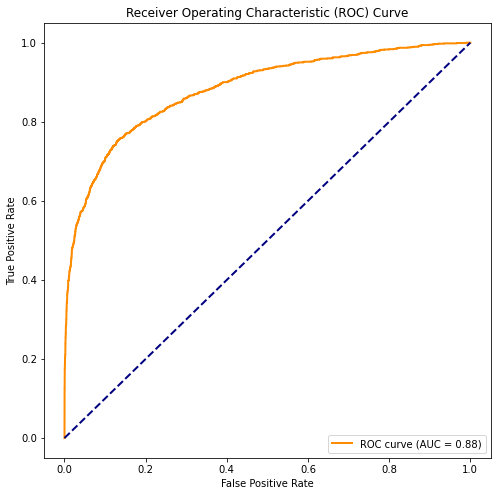

In [200]:
from sklearn.metrics import roc_curve, auc
y_probs = xgb_pipelineGridCV.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

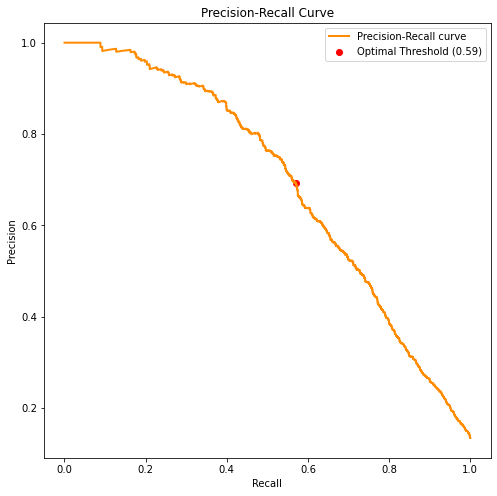

In [201]:
y_probs = xgb_pipelineGridCV.predict_proba(X_test)[:, 1]

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate F1 score at each threshold
f1_scores = [f1_score(y_test, (y_probs >= threshold).astype(int)) for threshold in thresholds]

# Find the index of the threshold that maximizes F1 score
optimal_threshold_index = f1_scores.index(max(f1_scores))
optimal_threshold = thresholds[optimal_threshold_index]

# Plot precision-recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.scatter(recall[optimal_threshold_index], precision[optimal_threshold_index], color='red', marker='o', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [202]:
#best model performance on the training dataset
print('Evaluation metrics on the training dataset')
xgb_train_perfcv = model_performance_classification_sklearn(xgb_pipelineGridCV, X_train, y_train, threshold=0.59)
display(xgb_train_perfcv)

#best model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
xgb_test_perfcv = model_performance_classification_sklearn(xgb_pipelineGridCV, X_test, y_test, threshold=0.59)
display(xgb_test_perfcv)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.994545,1.0,0.960993,0.980108


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.908134,0.565404,0.694503,0.62334


In [203]:
# Predictions on training set
train_preds = xgb_pipelineGridCV.predict(X_train)

# Predictions on test set
test_preds = xgb_pipelineGridCV.predict(X_test)

# Evaluate the final XGBoost model on training set
print("Training Set - XGBoost Classification Report:")
print(classification_report(y_train, train_preds))

xgb_train_report = classification_report(y_train, train_preds, output_dict=True)

xgb_train_avg_precision = xgb_train_report['weighted avg']['precision']
xgb_train_avg_recall = xgb_train_report['weighted avg']['recall']
xgb_train_avg_f1_score = xgb_train_report['weighted avg']['f1-score']
xgb_train_accuracy = xgb_train_report['accuracy']

xgb_test_report = classification_report(y_test, test_preds, output_dict=True)

xgb_test_avg_precision = xgb_test_report['weighted avg']['precision']
xgb_test_avg_recall = xgb_test_report['weighted avg']['recall']
xgb_test_avg_f1_score = xgb_test_report['weighted avg']['f1-score']
xgb_test_accuracy = xgb_test_report['accuracy']

# Evaluate the final XGBoost model on test set
print("\nTest Set - XGBoost Classification Report:")
print(classification_report(y_test, test_preds))

Training Set - XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17455
           1       0.93      1.00      0.96      2710

    accuracy                           0.99     20165
   macro avg       0.97      0.99      0.98     20165
weighted avg       0.99      0.99      0.99     20165


Test Set - XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7481
           1       0.63      0.60      0.62      1162

    accuracy                           0.90      8643
   macro avg       0.79      0.78      0.78      8643
weighted avg       0.90      0.90      0.90      8643



In [204]:
best_xgb_model1 = xgb_pipelineGridCV.named_steps['d_tree'].best_estimator_
# Get the transformed feature names
preprocessed_feature_names = xgb_pipelineGridCV.named_steps['col_transformer'].named_steps['columntransformer'].get_feature_names_out()
# Get feature importances
feature_importances = best_xgb_model1.feature_importances_
# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': preprocessed_feature_names, 'Importance': feature_importances})
# Sort the DataFrame by Importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Display the sorted DataFrame
 
pd.set_option('display.max_rows', None)
print(feature_importance_df)

                             Feature  Importance
9                          MONTH_DEC    0.105575
42                          DEST_EGE    0.083339
2                          CRS_DEP_M    0.030980
17              OP_UNIQUE_CARRIER_B6    0.026815
97           CONDITION_Light Drizzle    0.023521
84                          DEST_SRQ    0.023406
7                            SCH_DEP    0.022625
8                            SCH_ARR    0.021642
111             CONDITION_Wintry Mix    0.020003
85                          DEST_STT    0.016060
47                          DEST_IND    0.015435
10                         MONTH_JAN    0.014432
79                          DEST_SFO    0.013069
104          CONDITION_Mostly Cloudy    0.012789
40                          DEST_DFW    0.012396
29                          DEST_BTV    0.012026
5                         WIND_SPEED    0.011867
51                          DEST_LAX    0.011664
11                         MONTH_NOV    0.011360
89          CONDITIO

# Model comparision

In [205]:
pip install prettytable


Note: you may need to restart the kernel to use updated packages.


In [206]:
from prettytable import PrettyTable

# Create a PrettyTable
table = PrettyTable()
table.field_names = ["Train Metric", "Logistic", "Decision Tree", "Bagging","Isolation Forest", "OneClassSVM", "XGB", "XGB GridSearch"]

# Add data to the table
table.add_row(["Precision", log_train_avg_precision, dt_train_avg_precision, bagging_train_avg_precision, iso_train_avg_precision, svm_train_avg_precision, xgb_train_avg_precision1, xgb_train_avg_precision])
table.add_row(["Recall", log_train_avg_recall,dt_train_avg_recall, bagging_train_avg_recall, iso_train_avg_recall, svm_train_avg_recall, xgb_train_avg_recall1, xgb_train_avg_recall])
table.add_row(["F1-Score", log_train_avg_f1_score, dt_train_avg_f1_score, bagging_train_avg_f1_score, iso_train_avg_f1_score, svm_train_avg_f1_score, xgb_train_avg_f1_score1, xgb_train_avg_f1_score])
table.add_row(["Accuracy", log_train_accuracy, dt_train_accuracy, bagging_train_accuracy, iso_train_accuracy, svm_train_accuracy, xgb_train_accuracy1, xgb_train_accuracy])

# Print the table
print(table)


+--------------+--------------------+---------------+--------------------+--------------------+---------------------+--------------------+--------------------+
| Train Metric |      Logistic      | Decision Tree |      Bagging       |  Isolation Forest  |     OneClassSVM     |        XGB         |   XGB GridSearch   |
+--------------+--------------------+---------------+--------------------+--------------------+---------------------+--------------------+--------------------+
|  Precision   | 0.8441938793811816 |      1.0      | 0.987073684032294  | 0.769551252963931  | 0.01815548425909072 | 0.9512009412423842 | 0.9907634864600721 |
|    Recall    | 0.8670964542524175 |      1.0      | 0.9869080089263575 | 0.8302504339201587 | 0.12834118522191917 | 0.9496652615918671 | 0.9900818249442103 |
|   F1-Score   | 0.809021740353338  |      1.0      | 0.9866311511850052 | 0.7953737245365547 | 0.03181091251213252 | 0.9450261534781805 | 0.9902297305250591 |
|   Accuracy   | 0.8670964542524175 |   

In [207]:
# Create a PrettyTable
table = PrettyTable()
table.field_names = ["Test Metric", "Logistic", "Decision Tree", "Bagging","Isolation Forest", "OneClassSVM", "XGB", "XGB GridSearch"]

# Add data to the table
table.add_row(["Precision", log_test_avg_precision,dt_test_avg_precision,bagging_test_avg_precision,iso_test_avg_precision,svm_test_avg_precision,xgb_test_avg_precision1,xgb_test_avg_precision])
table.add_row(["Recall", log_test_avg_recall,dt_test_avg_recall,bagging_test_avg_recall,iso_test_avg_recall,svm_test_avg_recall,xgb_test_avg_recall1,xgb_test_avg_recall])
table.add_row(["F1-Score", log_test_avg_f1_score,dt_test_avg_f1_score,bagging_test_avg_f1_score,iso_test_avg_f1_score,svm_test_avg_f1_score,xgb_test_avg_f1_score1,xgb_test_avg_f1_score])
table.add_row(["Accuracy", log_test_accuracy, dt_test_accuracy, bagging_test_accuracy, iso_test_accuracy,svm_test_accuracy, xgb_test_accuracy1, xgb_test_accuracy])

# Print the table
print(table)


+-------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+
| Test Metric |      Logistic      |   Decision Tree    |      Bagging       |  Isolation Forest  |     OneClassSVM      |        XGB         |   XGB GridSearch   |
+-------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+
|  Precision  | 0.8312570918315252 | 0.8659859009876676 | 0.887998900217428  | 0.7740536127691702 | 0.018176967751673042 | 0.907677585517471  | 0.8981315726123893 |
|    Recall   | 0.8662501446257087 | 0.8677542519958348 | 0.8962165914612982 | 0.8320027768136063 | 0.12842762929538354  | 0.9127617725326854 | 0.9000347101700799 |
|   F1-Score  | 0.8074451710794669 | 0.8668476036776789 | 0.8750867166679909 | 0.798154251569895  | 0.03184654401221419  | 0.9004283057597017 | 0.8990254415023958 |
|   Accura

# Testing - Unseen Data

In [208]:
test_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 7821 to 17323
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              10 non-null     object 
 1   DAY_OF_WEEK        10 non-null     object 
 2   OP_UNIQUE_CARRIER  10 non-null     object 
 3   DEST               10 non-null     object 
 4   DEP_DELAY          10 non-null     int64  
 5   CRS_ELAPSED_TIME   10 non-null     int64  
 6   CRS_DEP_M          10 non-null     int64  
 7   TEMPERATURE        10 non-null     int64  
 8   DEW_POINT          10 non-null     int64  
 9   HUMIDITY           10 non-null     int64  
 10  WIND               10 non-null     int64  
 11  WIND_SPEED         10 non-null     int64  
 12  WIND_GUST          10 non-null     int64  
 13  PRESSURE           10 non-null     float64
 14  CONDITION          10 non-null     object 
 15  SCH_DEP            10 non-null     int64  
 16  SCH_ARR            10 

In [209]:
test_rows['DEP_DELAY'] = test_rows['DEP_DELAY'].apply(lambda x: 0 if x <= 15 else 1)
test_rows.shape

(10, 17)

In [210]:
test_rows1 = test_rows.drop('DEP_DELAY', axis=1)
predictions = xgb_pipelineGridCV.predict(test_rows1)
len(predictions)

10

In [211]:
results_df = pd.DataFrame({'True Labels': test_rows['DEP_DELAY'], 'Predictions': predictions})

# Display the DataFrame
print(results_df)

       True Labels  Predictions
7821             0            1
23733            1            1
21390            0            0
10152            0            0
11680            0            0
14315            0            0
27453            0            0
8478             0            0
6726             0            0
17323            0            0
